# DMLab 31/03/2025: Decision Tree and Random Forest

### 1. Bài toán: Dự đoán nguy cơ mắc bệnh tiểu đường ở giai đoạn đầu sử dụng Decision Tree và Random Forest (60%)
Mục tiêu:
- Xây dựng mô hình Decision Tree và Random Forest sử dụng thư viện sklearn.
- Khảo sát và tối ưu mô hình bằng việc tìm kiếm các siêu tham số và lựa chọn đặc trưng.
- Áp dụng hai mô hình để giải quyết bài toán thực tế (Dự đoán nguy cơ mắc bệnh).
- Đánh giá chất lượng mô hình bằng độ đo thích hợp.

Dữ liệu:
- Thể hiện dưới dạng bảng, trong đó mỗi hàng tương ứng với một bệnh nhân, mỗi cột thể hiện các dấu hiệu và triệu chứng của bệnh nhân đó.
- Các trường thuộc tính tồn tại ở hai dạng: binary và numeric (continuous).
- Thuộc tính nhãn lớp 'class' cũng là một thuộc tính nhị phân (Positive/Negative).

Mô hình hóa bài toán: Bài toán phân loại nhị phân
- Đầu vào: N vector D chiều (ma trận cỡ N x D), tương ứng N cá thể với D thuộc tính.
- Đầu ra: Nhãn 1/(-1) (1: Positive, -1: Negative).

Nhiệm vụ:
- Thực hiện theo các yêu cầu bên dưới.
- Viết báo cáo trình bày, giải thích chi tiết các bước và nhận xét kết quả thu được.

### 2. Các bước thực hiện

#### 2.1. Import các thư viện cần thiết

In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt

#### 2.2. Tìm hiểu dữ liệu

In [38]:
''' Thông tin chi tiết về tập dữ liệu có thể xem tại trang web UCI
https://archive.ics.uci.edu/dataset/529/early+stage+diabetes+risk+prediction+dataset
'''
# Xem thông tin chi tiết
data = pd.read_csv('../data/diabetes_data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Age                 520 non-null    int64 
 1   Gender              520 non-null    object
 2   Polyuria            520 non-null    object
 3   Polydipsia          520 non-null    object
 4   sudden weight loss  520 non-null    object
 5   weakness            520 non-null    object
 6   Polyphagia          520 non-null    object
 7   Genital thrush      520 non-null    object
 8   visual blurring     520 non-null    object
 9   Itching             520 non-null    object
 10  Irritability        520 non-null    object
 11  delayed healing     520 non-null    object
 12  partial paresis     520 non-null    object
 13  muscle stiffness    520 non-null    object
 14  Alopecia            520 non-null    object
 15  Obesity             520 non-null    object
 16  class               520 no

In [6]:
data.isnull().sum() # Kiểm tra missing value

Age                   0
Gender                0
Polyuria              0
Polydipsia            0
sudden weight loss    0
weakness              0
Polyphagia            0
Genital thrush        0
visual blurring       0
Itching               0
Irritability          0
delayed healing       0
partial paresis       0
muscle stiffness      0
Alopecia              0
Obesity               0
class                 0
dtype: int64

In [39]:
# Mã hóa dữ liệu dạng category thành numeric
label_map = {'Negative' : -1, 'Positive': 1}
data['class'] = data['class'].map(label_map)
gender_map = {'Male': 1, 'Female': 0}
data['Gender'] = data['Gender'].map(gender_map)
other_map = {'Yes': 1, 'No': 0}
for col in data.columns:
    if col not in ['Age', 'Gender', 'class']:
        data[col] = data[col].map(other_map)

In [19]:
# Yêu cầu 1:
''' - Giải thích chức năng của đoạn code trên
    - Kết quả thu được sau khi chuẩn hóa là gì?
    
    - Giải thích chức năng của đoạn: 
     + Đoạn code này mã hóa dữ liệu từ dạng category thành dạng numeric để thuận tiện cho việc xử lý và huấn luyện mô hình.
     
    - Kết quả thu được:
     + Cột class sẽ chuyển từ giá trị 'Negative' thành -1 và 'Positive' thành 1.
     + Cột Gender sẽ chuyển từ 'Male' thnafh 1 và 'Female' thành 0.
     + Tất cả các cột khác (ngoại trừ 'Age', 'Gender', 'class') sẽ chuyển giá trị từ 'Yes' thành 1 và 'No' thành 0.
'''
data

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,40,1,0,1,0,1,0,0,0,1,0,1,0,1,1,1,1
1,58,1,0,0,0,1,0,0,1,0,0,0,1,0,1,0,1
2,41,1,1,0,0,1,1,0,0,1,0,1,0,1,1,0,1
3,45,1,0,0,1,1,1,1,0,1,0,1,0,0,0,0,1
4,60,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515,39,0,1,1,1,0,1,0,0,1,0,1,1,0,0,0,1
516,48,0,1,1,1,1,1,0,0,1,1,1,1,0,0,0,1
517,58,0,1,1,1,1,1,0,1,0,0,0,1,1,0,1,1
518,32,0,0,0,0,1,0,0,1,1,0,1,0,0,1,0,-1


In [30]:
data.info() # Kiểm tra lại thông tin dữ liệu

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   Age                 520 non-null    int64
 1   Gender              520 non-null    int64
 2   Polyuria            520 non-null    int64
 3   Polydipsia          520 non-null    int64
 4   sudden weight loss  520 non-null    int64
 5   weakness            520 non-null    int64
 6   Polyphagia          520 non-null    int64
 7   Genital thrush      520 non-null    int64
 8   visual blurring     520 non-null    int64
 9   Itching             520 non-null    int64
 10  Irritability        520 non-null    int64
 11  delayed healing     520 non-null    int64
 12  partial paresis     520 non-null    int64
 13  muscle stiffness    520 non-null    int64
 14  Alopecia            520 non-null    int64
 15  Obesity             520 non-null    int64
 16  class               520 non-null    int64
dt

In [40]:
# Yêu cầu 2: Chuẩn hóa dữ liệu
####
# Code
y_class = data['class']
data = data.drop(['class'], axis=1)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

data = scaler.fit_transform(data)
####

In [41]:
# Yêu cầu 3: Chuẩn bị tập train-test cho mô hình học máy
####
# Code
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, y_class, test_size=0.2, random_state=42)

####

#### 2.3. Khởi tạo mô hình Decision Tree (DT) và Random Forest (RF) của sklearn

In [42]:
random_state = 42
DT = DecisionTreeClassifier(random_state=random_state)
RF = RandomForestClassifier(random_state=random_state)

Demo DT prediction
              precision    recall  f1-score   support

          -1       0.87      1.00      0.93        33
           1       1.00      0.93      0.96        71

    accuracy                           0.95       104
   macro avg       0.93      0.96      0.95       104
weighted avg       0.96      0.95      0.95       104



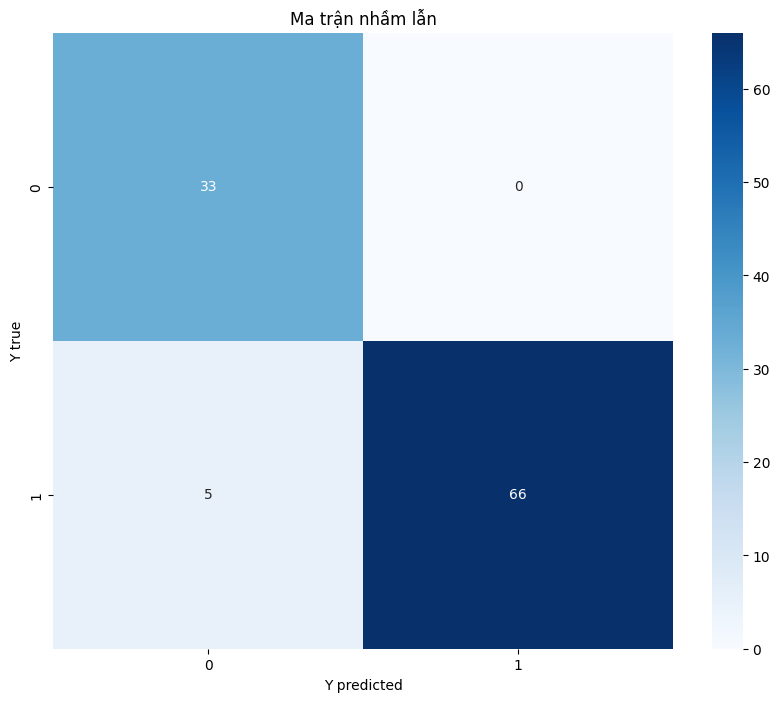

In [48]:
# Yêu cầu 4: Chạy DT baseline
''' - Huấn luyện mô hình DT vừa khởi tạo với tập Train
    - Đánh giá mô hình DT đã huấn luyện với tập Test
    - In ra giá trị các độ đo: Accuracy, Precision, Recall, F1-Score, Ma trận nhầm lẫn (Có thể sử dụng thư viện sklearn hoặc viết tay)
    - Giải thích các kết quả trong ma trận nhầm lẫn
'''
####
print('Demo DT prediction')
#Code
dt_model = DT.fit(X_train, y_train)
dt_pred = dt_model.predict(X_test)

print(classification_report(y_test, dt_pred))

# Ma trận nhầm lẫn
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test, dt_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Ma trận nhầm lẫn')
plt.ylabel('Y true')
plt.xlabel('Y predicted')
plt.show()

####

Demo RF prediction
              precision    recall  f1-score   support

          -1       0.97      1.00      0.99        33
           1       1.00      0.99      0.99        71

    accuracy                           0.99       104
   macro avg       0.99      0.99      0.99       104
weighted avg       0.99      0.99      0.99       104



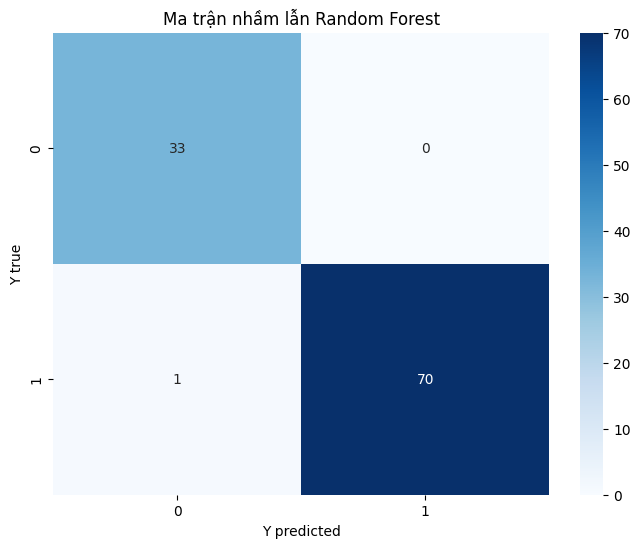

In [50]:
# Yêu cầu 5: Chạy RF baseline
''' - Huấn luyện mô hình RF vừa khởi tạo với tập Train
    - Đánh giá mô hình RF đã huấn luyện với tập Test
    - In ra giá trị các độ đo: Accuracy, Precision, Recall, F1-Score, Ma trận nhầm lẫn (Có thể sử dụng thư viện sklearn hoặc viết tay)
    - Giải thích các kết quả trong ma trận nhầm lẫn
'''
####
print('Demo RF prediction')
#Code
rf_model = RF.fit(X_train, y_train)
ft_pred = rf_model.predict(X_test)

# Đánh giá
print(classification_report(y_test, ft_pred))

# Ma trận nhầm lẫn
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, ft_pred), cmap="Blues", annot=True, fmt="d")
plt.title("Ma trận nhầm lẫn Random Forest")
plt.ylabel('Y true')
plt.xlabel('Y predicted')
plt.show()


####

#### 2.4. Tìm kiếm siêu tham số

In [51]:
# Sử dụng kỹ thuật grid_search
def grid_search(algorithm, X_train, y_train, n_jobs, dict_param):
    if algorithm == 'decision-tree':
        model = DecisionTreeClassifier()
    if algorithm == 'random-forest':
        model = RandomForestClassifier()
    classifier = GridSearchCV(estimator=model, cv=5, param_grid=dict_param, n_jobs=n_jobs, scoring='f1')
    classifier.fit(X_train, y_train)
    print('Best model', end='')
    print(classifier.best_estimator_)
    print("Best parameters:", classifier.best_params_)
    return classifier.best_estimator_

# Đánh giá hiệu suất
def evaluate(X_train, y_train, X_test, y_test, model):
    print("Train Accuracy:", accuracy_score(y_train, model.predict(X_train)))
    print("Train Precision: ", precision_score(y_train, model.predict(X_train)))
    print("Train Recall: ", recall_score(y_train, model.predict(X_train)))
    print("Train F1-score:", f1_score(y_train, model.predict(X_train)))
    print("Train Confusion Matrix:")
    print(confusion_matrix(y_train, model.predict(X_train)))
    print("-"*50)
    print("Test Accuracy:", accuracy_score(y_test, model.predict(X_test)))
    print("Test Precision:", precision_score(y_test, model.predict(X_test)))
    print("Test Recall: ", recall_score(y_test, model.predict(X_test)))
    print("Test F1-score:", f1_score(y_test, model.predict(X_test)))
    print("Test Confusion Matrix:")
    print(confusion_matrix(y_test, model.predict(X_test)))
    return f1_score(y_train, model.predict(X_train)), f1_score(y_test, model.predict(X_test))

In [ ]:
# Yêu cầu 6:
''' Giải thích chức năng của hàm grid_search và evaluate'''

##### 2.4.1. Decision Tree (DT)

##### Trước hết, hãy thử khảo sát DT với siêu tham số: max_depth (độ sâu của cây)

Text(0.5, 1.0, 'DT validation curve for max_depth')

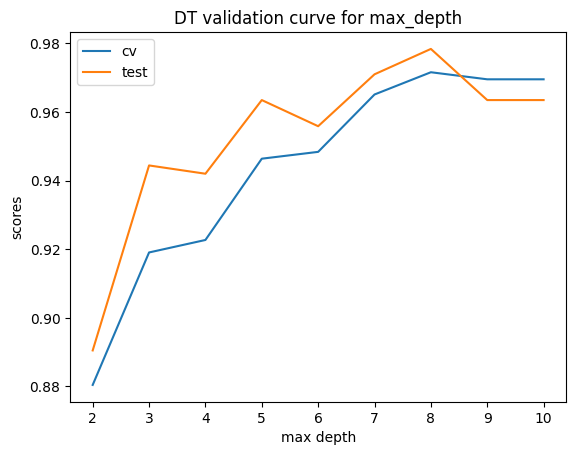

In [52]:
cv_accuracies_by_depth, test_accuracies_by_depth= [], []
max_depth_values= np.arange(2,11)

for curr_max_depth in max_depth_values:
  tree= DecisionTreeClassifier(random_state=random_state, max_depth=curr_max_depth)

  # cross-validation
  val_scores= cross_val_score(estimator=tree, X=X_train, y=y_train, cv=5, scoring='f1')
  cv_accuracies_by_depth.append(val_scores.mean())

  # test
  tree.fit(X_train, y_train)
  curr_pred= tree.predict(X_test)
  test_accuracies_by_depth.append(f1_score(curr_pred, y_test))

# Plot
plt.plot(max_depth_values, cv_accuracies_by_depth, label='cv')
plt.plot(max_depth_values, test_accuracies_by_depth, label='test')
plt.legend()
plt.xlabel('max depth')
plt.ylabel('scores')
plt.title('DT validation curve for max_depth')

In [ ]:
# Yêu cầu 7:
''' - Giải thích chức năng của đoạn code trên
    - Nhận xét biểu đồ thu được
'''

##### Thử sử dụng GridSearchCV để khảo sát

In [54]:
dict_param = {
    'max_depth': [2, 3, 5, 7, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}
best_tree = grid_search('decision-tree', X_train, y_train, n_jobs=-1, dict_param=dict_param)

Best modelDecisionTreeClassifier(max_depth=5, min_samples_leaf=5)
Best parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 5}


In [ ]:
# Yêu cầu 8:
''' - Giải thích ý nghĩa của các biến: max_depth, min_samples_leaf, criterion trong mô hình DT
    - Grid_seach được sử dụng nhằm mục đích gì?
    - Kết quả thu được là gì?
'''

##### Đánh giá Mô hình DT tốt nhất

In [55]:
# Yêu cầu 9: Gợi ý: Sử dụng hàm evaluate()
####
#Code
evaluate(X_train, y_train, X_test, y_test, dt_model)
####

Train Accuracy: 1.0
Train Precision:  1.0
Train Recall:  1.0
Train F1-score: 1.0
Train Confusion Matrix:
[[167   0]
 [  0 249]]
--------------------------------------------------
Test Accuracy: 0.9519230769230769
Test Precision: 1.0
Test Recall:  0.9295774647887324
Test F1-score: 0.9635036496350365
Test Confusion Matrix:
[[33  0]
 [ 5 66]]


(1.0, 0.9635036496350365)

##### Nhận xét về độ quan trọng của từng feature trong tập dữ liệu sử dụng thuộc tính feature_importances_

Feature importances
Feature  0 - 0.5349240515639837
Feature  1 - 0.1170855258472535
Feature  2 - 0.09111188013941363
Feature  3 - 0.061799494961234824
Feature  4 - 0.0556327698410298
Feature  5 - 0.04090476661971969
Feature  6 - 0.03762032705052176
Feature  7 - 0.028540164078943907
Feature  8 - 0.02205376315191121
Feature  9 - 0.008307938249832046
Feature  10 - 0.0020193184961559115
Feature  11 - 0.0
Feature  12 - 0.0
Feature  13 - 0.0
Feature  14 - 0.0
Feature  15 - 0.0


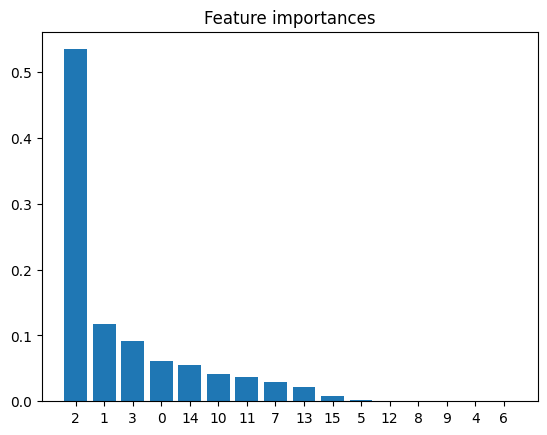

In [56]:
importances = best_tree.feature_importances_
indices = np.argsort(importances)[::-1]
print('Feature importances')
for i in range(len(indices)):
    print('Feature ', i, '-', importances[indices[i]])

indices = indices[:]
plt.figure()
plt.title('Feature importances')
plt.bar(range(len(indices)), importances[indices])
plt.xticks(range(len(indices)), indices)
plt.show()

In [ ]:
# Yêu cầu 10:
'''
    - Giải thích chức năng của đoạn code trên
    - Nhận xét kết quả thu được từ biểu đồ
'''

##### Thử nghiệm bổ sung: Thử bỏ đi một số thuộc tính có độ quan trọng thấp và quan sát sự thay đổi của hiệu suất mô hình

Loại bỏ 1 thuộc tính
15 thuộc tính còn lại: [ 2  1  3  0 14 10 11  7 13 15  5 12  8  9  4]
(416, 15) (104, 15)
Train Accuracy: 0.9543269230769231
Train Precision:  0.9914529914529915
Train Recall:  0.9317269076305221
Train F1-score: 0.9606625258799172
Train Confusion Matrix:
[[165   2]
 [ 17 232]]
--------------------------------------------------
Test Accuracy: 0.9326923076923077
Test Precision: 1.0
Test Recall:  0.9014084507042254
Test F1-score: 0.9481481481481482
Test Confusion Matrix:
[[33  0]
 [ 7 64]]
**************************************************
Loại bỏ 2 thuộc tính
14 thuộc tính còn lại: [ 2  1  3  0 14 10 11  7 13 15  5 12  8  9]
(416, 14) (104, 14)
Train Accuracy: 0.9543269230769231
Train Precision:  0.9914529914529915
Train Recall:  0.9317269076305221
Train F1-score: 0.9606625258799172
Train Confusion Matrix:
[[165   2]
 [ 17 232]]
--------------------------------------------------
Test Accuracy: 0.9326923076923077
Test Precision: 1.0
Test Recall:  0.9014084507042254
Te

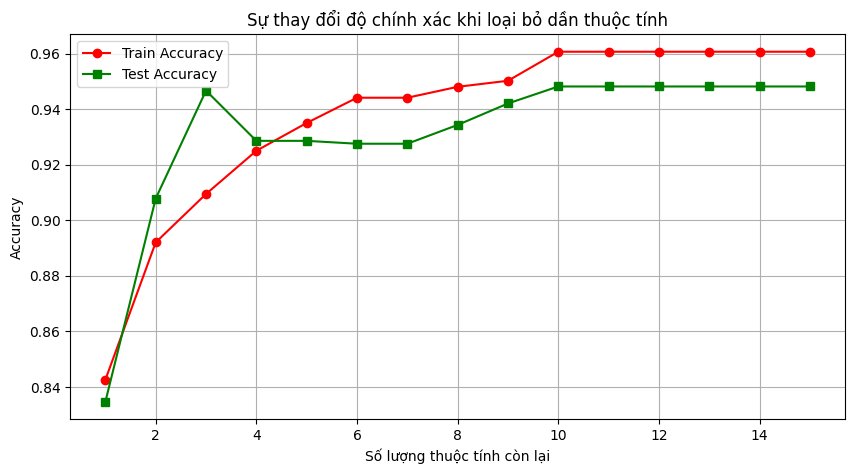

In [57]:
train_scores = []
test_scores = []
num_features = []

for i in range(1, len(indices)):
    print(f'Loại bỏ {i} thuộc tính')

    selected_indices = indices[:-i]
    print(f'{len(selected_indices)} thuộc tính còn lại: {selected_indices}')

    X_train_reduced = X_train[:, selected_indices]
    X_test_reduced = X_test[:, selected_indices]
    print(X_train_reduced.shape, X_test_reduced.shape)

    best_tree.fit(X_train_reduced, y_train)
    
    train_acc, test_acc = evaluate(X_train_reduced, y_train, X_test_reduced, y_test, best_tree)
    
    train_scores.append(train_acc)
    test_scores.append(test_acc)
    num_features.append(len(selected_indices))

    print('*' * 50)

# Vẽ biểu đồ
plt.figure(figsize=(10, 5))
plt.plot(num_features, train_scores, label='Train Accuracy', marker='o', color='r')
plt.plot(num_features, test_scores, label='Test Accuracy', marker='s', color='g')

plt.xlabel('Số lượng thuộc tính còn lại')
plt.ylabel('Accuracy')
plt.title('Sự thay đổi độ chính xác khi loại bỏ dần thuộc tính')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Yêu cầu 11:
'''
    - Giải thích chức năng của đoạn code trên
    - Nhận xét kết quả thu được từ biểu đồ
'''

#### 2.4.2. Thực hành tương tự với Random Forest (RF)

##### Trước hết, thử khảo sát RF với siêu tham số: n_estimators (số lượng cây)

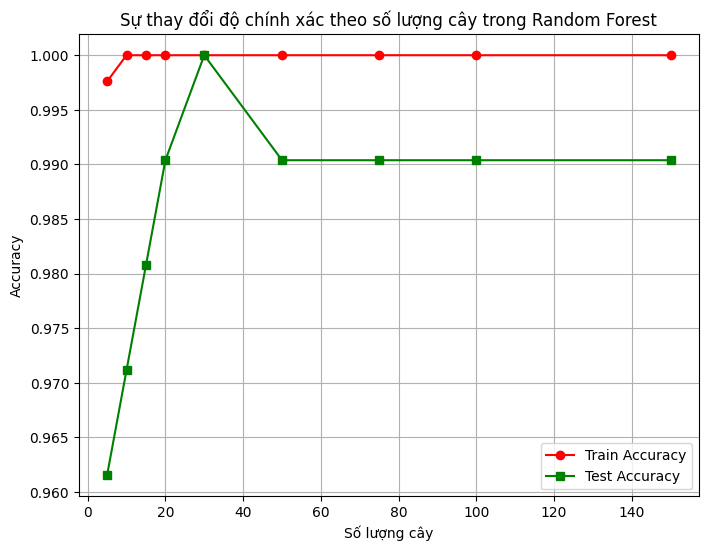

In [62]:
num_trees = [5, 10, 15, 20, 30, 50, 75, 100, 150]
train_acc = []
test_acc = []
####
# Yêu cầu 12: Code
# Vẽ biểu đồ biểu thị mối quan hệ giữa số lượng cây và độ chính xác
# Nhận xét kết quả
for n in num_trees:
    rf_model = RandomForestClassifier(n_estimators=n, random_state=42)
    rf_model.fit(X_train, y_train)
    
    train_acc.append(rf_model.score(X_train, y_train))
    test_acc.append(rf_model.score(X_test, y_test))

plt.figure(figsize=(8, 6))
plt.plot(num_trees, train_acc, label='Train Accuracy', marker='o', color='r')
plt.plot(num_trees, test_acc, label='Test Accuracy', marker='s', color='g')

plt.xlabel('Số lượng cây')
plt.ylabel('Accuracy')
plt.title('Sự thay đổi độ chính xác theo số lượng cây trong Random Forest')
plt.legend()
plt.grid(True)
plt.show()

####

##### Sử dụng GridSearchCV để khảo sát

In [59]:
dict_param = {
    'max_depth': [3, 11, 15, 24, 27],
    'min_samples_leaf': [1, 5, 7, 9, 15, 24],
    'max_features':  [4, 6, 10, 16],
    'n_estimators': [20, 30, 40]
}
best_forest = grid_search('random-forest', X_train, y_train, n_jobs=-1, dict_param=dict_param)

Best modelRandomForestClassifier(max_depth=11, max_features=4, n_estimators=30)
Best parameters: {'max_depth': 11, 'max_features': 4, 'min_samples_leaf': 1, 'n_estimators': 30}


In [ ]:
# Yêu cầu 13:
''' - Giải thích ý nghĩa của các biến: max_depth, min_samples_leaf, max_features, n_estimators trong mô hình RF
    - Grid_seach được sử dụng nhằm mục đích gì?
    - Kết quả thu được là gì?
'''

##### Đánh giá Mô hình RF tốt nhất

In [63]:
# Yêu cầu 14: Gợi ý: Sử dụng hàm evaluate()
####
#Code
evaluate(X_train, y_train, X_test, y_test, rf_model)
####

Train Accuracy: 1.0
Train Precision:  1.0
Train Recall:  1.0
Train F1-score: 1.0
Train Confusion Matrix:
[[167   0]
 [  0 249]]
--------------------------------------------------
Test Accuracy: 0.9903846153846154
Test Precision: 1.0
Test Recall:  0.9859154929577465
Test F1-score: 0.9929078014184397
Test Confusion Matrix:
[[33  0]
 [ 1 70]]


(1.0, 0.9929078014184397)

##### Nhận xét về độ quan trọng của từng feature trong tập dữ liệu sử dụng thuộc tính feature_importances_

In [ ]:
# Yêu cầu 15:
####
# Code
# Vẽ biểu đồ hiển thị các feature giảm dần theo độ quan trọng
# Nhận xét kết quả

####

##### Thử nghiệm bổ sung: Thử bỏ đi một số thuộc tính có độ quan trọng thấp và quan sát sự thay đổi của hiệu suất mô hình

Loại bỏ 1 thuộc tính
15 thuộc tính còn lại: [ 3  2  1  0 12  4 10 11 14  8  9 13  7  6  5]
(416, 15) (104, 15)
Train Accuracy: 0.9975961538461539
Train Precision:  0.996
Train Recall:  1.0
Train F1-score: 0.9979959919839679
Train Confusion Matrix:
[[166   1]
 [  0 249]]
--------------------------------------------------
Test Accuracy: 0.9807692307692307
Test Precision: 1.0
Test Recall:  0.971830985915493
Test F1-score: 0.9857142857142858
Test Confusion Matrix:
[[33  0]
 [ 2 69]]
**************************************************
Loại bỏ 2 thuộc tính
14 thuộc tính còn lại: [ 3  2  1  0 12  4 10 11 14  8  9 13  7  6]
(416, 14) (104, 14)
Train Accuracy: 1.0
Train Precision:  1.0
Train Recall:  1.0
Train F1-score: 1.0
Train Confusion Matrix:
[[167   0]
 [  0 249]]
--------------------------------------------------
Test Accuracy: 0.9807692307692307
Test Precision: 1.0
Test Recall:  0.971830985915493
Test F1-score: 0.9857142857142858
Test Confusion Matrix:
[[33  0]
 [ 2 69]]
****************

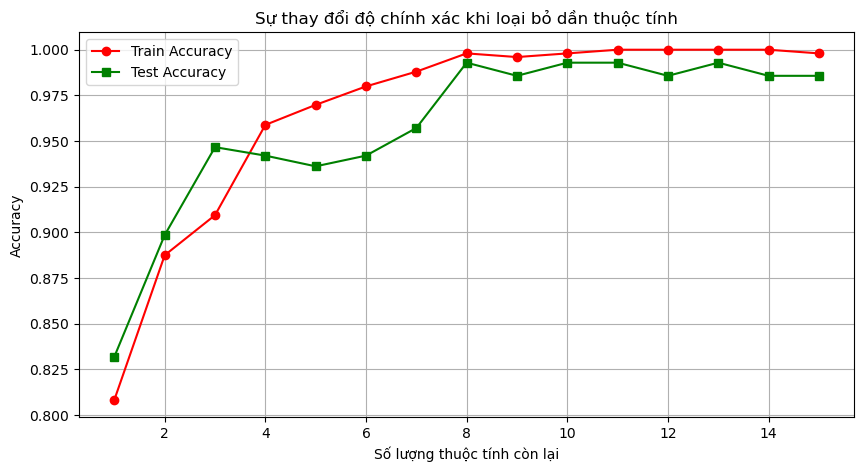

In [ ]:
# Yêu cầu 16:
####
# Code
# Vẽ biểu đồ biểu thị sự thay đổi của f1-score khi loại bỏ dần các thuộc tính trên cả tập train và test
# Nhận xét kết quả
####

### 2. Bài toán: Dự điểm số của học sinh dựa sử dụng Decsion Tree và Random Forest (40%)
Mục tiêu:
- Xây dựng mô hình Decision Tree Regression và Random Forest Regression sử dụng thư viện sklearn.
- Khảo sát và tối ưu mô hình bằng việc tìm kiếm các siêu tham số và lựa chọn đặc trưng.
- Áp dụng hai mô hình để giải quyết bài toán thực tế (Dự đoán điểm số).
- Đánh giá chất lượng mô hình bằng độ đo thích hợp.

Dữ liệu:
- Thể hiện dưới dạng bảng, trong đó mỗi hàng tương ứng với một học sinh, mỗi cột thể hiện thông tin cá nhân, học tập, và môi trường sống của học sinh.
- Các trường thuộc tính tồn tại ở nhiều dạng khác nhau: category, binary, numeric.
- Thuộc tính nhãn lớp 'G3' là một thuộc tính có kiểu dữ liệu numeric.

Mô hình hóa bài toán: Bài toán hồi quy (Regression Task)
- Đầu vào: N vector D chiều (ma trận cỡ N x D), tương ứng N cá thể với D thuộc tính.
- Đầu ra: Điểm số cụ thể của học sinh.

Nhiệm vụ:
- Tìm hiểu và tải dữ liệu về từ trang: https://archive.ics.uci.edu/dataset/320/student+performance.
- Giải nén folder 'student.zip'. Sau đó, hợp nhất dữ liệu ở 2 file csv có tên 'student-mat.csv' và 'student-por.csv' thành 1 file đặt tên là 'student.csv'.
- 'student.csv' chính là dataset cuối cùng dùng cho Bài toán 2.
- Tiếp tục thực hiện các bước tương tự như Bài toán 1.
- Viết báo cáo trình bày, giải thích chi tiết các bước và nhận xét kết quả thu được.